## course content

1. lenet 模型介绍
2. lenet 网络搭建
3. 运用lenet进行图像识别-fashion-mnist数据集



#  Convolutional Neural Networks

使用全连接层的局限性：

- 图像在同一列邻近的像素在这个向量中可能相距较远。它们构成的模式可能难以被模型识别。
- 对于大尺寸的输入图像，使用全连接层容易导致模型过大。

使用卷积层的优势：

- 卷积层保留输入形状。
- 卷积层通过滑动窗口将同一卷积核与不同位置的输入重复计算，从而避免参数尺寸过大。




## LeNet 模型

LeNet分为**卷积层块**和**全连接层块**两个部分。下面我们分别介绍这两个模块。


![Image Name](https://cdn.kesci.com/upload/image/q5ndwsmsao.png?imageView2/0/w/960/h/960)


**卷积层块**里的基本单位是卷积层后接平均池化层：**卷积层用来识别图像里的空间模式**，如线条和物体局部，之后的**平均池化层则用来降低卷积层对位置的敏感性。**

卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使用$5 \times 5$的窗口，并在输出上使用sigmoid激活函数。第一个卷积层输出通道数为6，第二个卷积层输出通道数则增加到16（长宽减少、通道数增加 -> 尽可能的保留特征）。

全连接层块含3个全连接层。它们的输出个数分别是120、84和10，其中10为输出的类别个数。

下面我们通过Sequential类来实现LeNet模型。

In [1]:
#import
import sys
sys.path.append("/home/xixixi/桌面/Dive-into-DL-PyTorch/code")
import d2lzh_pytorch as d2l
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [3]:
#net
class Flatten(torch.nn.Module):  #展平操作 降维打击，降至一维
    def forward(self, x):
        return x.view(x.shape[0], -1)

class Reshape(torch.nn.Module): #将图像大小重定型
    def forward(self, x):
        return x.view(-1,1,28,28)      #(B x C x H x W)
    
net = torch.nn.Sequential(     #Lelet                                                  
    Reshape(),
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), #b*1*28*28  =>b*6*28*28
    nn.Sigmoid(),                                                       
    nn.AvgPool2d(kernel_size=2, stride=2),                              #b*6*28*28  =>b*6*14*14
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),           #b*6*14*14  =>b*16*10*10
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),                              #b*16*10*10  => b*16*5*5
    Flatten(),                                                          #b*16*5*5   => b*400
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

接下来我们构造一个高和宽均为28的单通道数据样本，并逐层进行前向计算来查看每个层的输出形状。

In [4]:
#print
X = torch.randn(size=(1,1,28,28), dtype = torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


可以看到，在卷积层块中输入的高和宽在逐层减小。卷积层由于使用高和宽均为5的卷积核，从而将高和宽分别减小4，而池化层则将高和宽减半，但通道数则从1增加到16。全连接层则逐层减少输出个数，直到变成图像的类别数10。


![Image Name](https://cdn.kesci.com/upload/image/q5ndxi6jl5.png?imageView2/0/w/640/h/640)


## 获取数据和训练模型

下面我们来实现LeNet模型。我们仍然使用Fashion-MNIST作为训练数据集。

In [5]:
# 数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
print(len(train_iter))


235


### 数据展示
为了使读者更加形象的看到数据，添加额外的部分来展示数据的图像

torch.Size([1, 28, 28]) 8
torch.Size([1, 28, 28]) 1
torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 5
torch.Size([1, 28, 28]) 1
torch.Size([1, 28, 28]) 8
torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 3
torch.Size([1, 28, 28]) 5
torch.Size([1, 28, 28]) 1


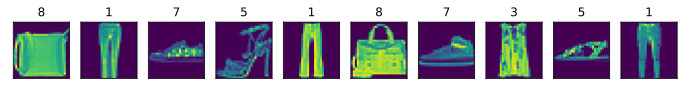

In [7]:

import matplotlib.pyplot as plt
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

for Xdata,ylabel in train_iter:
    break
X, y = [], []
for i in range(10):
    print(Xdata[i].shape,ylabel[i].numpy())
    X.append(Xdata[i]) # 将第i个feature加到X中
    y.append(ylabel[i].numpy()) # 将第i个label加到y中
show_fashion_mnist(X, y)

因为卷积神经网络计算比多层感知机要复杂，建议使用GPU来加速计算。我们查看看是否可以用GPU，如果成功则使用`cuda:0`，否则仍然使用`cpu`。

In [8]:
# This function has been saved in the d2l package for future use
#use GPU
def try_gpu():
    """If GPU is available, return torch.device as cuda:0; else return torch.device as cpu."""
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = try_gpu()
device

device(type='cpu')

我们实现`evaluate_accuracy`函数，该函数用于计算模型`net`在数据集`data_iter`上的准确率。

### 计算准确率

(1). net.train()

  启用 BatchNormalization 和 Dropout，将BatchNormalization和Dropout置为True
  
(2). net.eval()

不启用 BatchNormalization 和 Dropout，将BatchNormalization和Dropout置为False


In [12]:
def evaluate_accuracy(data_iter, net,device=torch.device('cpu')):
    #Evaluate accuracy of a model on the given data set.
    acc_sum,n = torch.tensor([0],dtype=torch.float32,device=device),0
    for X,y in data_iter:
        # If device is the GPU, copy the data to the GPU.
        X,y = X.to(device),y.to(device) #把tensor变量copy到计算设备上
        net.eval()
        with torch.no_grad(): #不需要计算梯度 也不进行反向传播
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))  #[[0.2 ,0.4 ,0.5 ,0.6 ,0.8] ,[ 0.1,0.2 ,0.4 ,0.3 ,0.1]] => [ 4 , 2 ]
            #先将一个批次的数据X 通过net() 输出net(X) 再通过argmax（返回特定维度（此函数dim=1）上最大值对应的索引） 得到预测值
            n += y.shape[0]
    return acc_sum.item()/n

我们定义函数`train_ch5`，用于训练模型。

In [13]:
#训练函数
def train_ch5(net, train_iter, test_iter,criterion, num_epochs, batch_size, device,lr=None):
                                         #损失函数
    """Train and evaluate a model with CPU or GPU."""
    print('training on', device)
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_l_sum = torch.tensor([0.0],dtype=torch.float32,device=device)
        train_acc_sum = torch.tensor([0.0],dtype=torch.float32,device=device)
        n, start = 0, time.time()
        for X, y in train_iter:
            net.train()
            
            optimizer.zero_grad()
            X,y = X.to(device),y.to(device) 
            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                y = y.long()
                train_l_sum += loss.float()
                train_acc_sum += (torch.sum((torch.argmax(y_hat, dim=1) == y))).float()
                n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net,device)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc,
                 time.time() - start))

我们重新将模型参数初始化到对应的设备`device`(`cpu` or `cuda:0`)之上，并使用Xavier随机初始化。损失函数和训练算法则依然使用交叉熵损失函数和小批量随机梯度下降。

In [14]:
# 训练
lr, num_epochs = 0.9, 10

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
net = net.to(device)

criterion = nn.CrossEntropyLoss()   #交叉熵描述了两个概率分布之间的距离，交叉熵越小说明两者之间越接近
train_ch5(net, train_iter, test_iter, criterion,num_epochs, batch_size,device, lr)

training on cpu
epoch 1, loss 0.0091, train acc 0.107, test acc 0.103, time 17.3 sec
epoch 2, loss 0.0050, train acc 0.492, test acc 0.586, time 18.4 sec
epoch 3, loss 0.0033, train acc 0.670, test acc 0.670, time 17.0 sec
epoch 4, loss 0.0027, train acc 0.729, test acc 0.743, time 19.5 sec
epoch 5, loss 0.0024, train acc 0.760, test acc 0.745, time 15.5 sec
epoch 6, loss 0.0022, train acc 0.782, test acc 0.774, time 15.5 sec
epoch 7, loss 0.0021, train acc 0.798, test acc 0.795, time 17.0 sec
epoch 8, loss 0.0019, train acc 0.813, test acc 0.784, time 17.8 sec
epoch 9, loss 0.0019, train acc 0.821, test acc 0.815, time 16.9 sec
epoch 10, loss 0.0018, train acc 0.831, test acc 0.802, time 16.0 sec


In [16]:
# test
for testdata,testlabe in test_iter:
    testdata,testlabe = testdata.to(device),testlabe.to(device)
    break
print(testdata.shape,testlabe.shape)
net.eval()
y_pre = net(testdata)
print(torch.argmax(y_pre,dim=1)[:10])
print(testlabe[:10])

torch.Size([256, 1, 28, 28]) torch.Size([256])
tensor([9, 2, 1, 1, 2, 1, 2, 6, 5, 7])
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])


## 总结：

卷积神经网络就是含卷积层的网络。
LeNet交替使用卷积层和最大池化层后接全连接层来进行图像分类。